In [1]:
#import xmltodict, json
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Convert dataset

In [4]:
o = xmltodict.parse(open("all.xml",'r',encoding='utf-8').read())
a  = json.dumps(o, indent=2,ensure_ascii=False) # '{"e": {"a": ["text", "text"]}}'

In [6]:
with open("all.json", 'w', encoding='utf-8') as fd:
    fd.write(a)

## Filter dataset

In [2]:
import json

In [3]:
with open("../data/all.json", 'r', encoding='utf-8') as fd:
    data = json.loads(fd.read())

In [4]:
BASE_MODEL = "ai-forever/ruGPT-3.5-13B"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

In [6]:
text_lens, title_lens, author_lens = [], [], []
selected_item_ids = []
text_char_lens = []

no_title_ids = []

for i, item in tqdm(enumerate(data['items']['item'])):
    encoded_t = tokenizer.encode(item['text'])
    if len(encoded_t) >= 500:
        continue

    if item['name'] is not None and item['author'] is not None:
        selected_item_ids.append(i)

        author_lens.append(len(tokenizer.encode(item['author'])))
        title_lens.append(len(tokenizer.encode(item['name'])))
        text_lens.append(len(encoded_t))
        
        text_char_lens.append(len(item['text']))
    else:
        no_title_ids.append(i)

print(len(no_title_ids), len(text_lens))

43it [00:00, 81.50it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (2390 > 2048). Running this sequence through the model will result in indexing errors
16694it [00:47, 348.96it/s]

505 14846


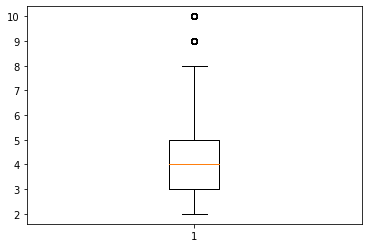

In [32]:
plt.boxplot(author_lens)
plt.show()

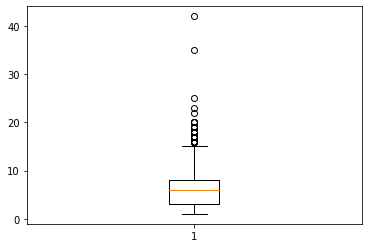

In [33]:
plt.boxplot(title_lens)
plt.show()

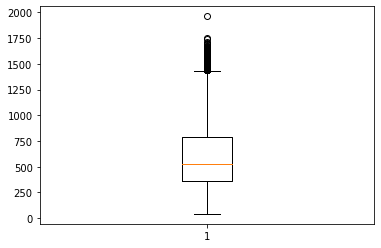

In [34]:
plt.boxplot(text_char_lens)
plt.show()

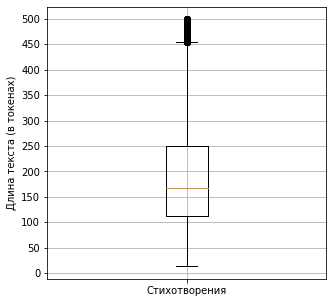

In [28]:
f, axs = plt.subplots(1, 1, figsize=(5, 5))

plt.boxplot(text_lens)
plt.yticks(list(range(0,510,50)))
plt.ylabel("Длина текста (в токенах)")
axs.set_xticklabels(["Cтихотворения"])
plt.grid()
plt.show()

In [31]:
import numpy as np

In [32]:
print(min(text_lens),max(text_lens), np.mean(text_lens))

13 499 190.26586285868248


In [33]:
df = pd.DataFrame([[data['items']['item'][i]['text'],data['items']['item'][i]['name'],data['items']['item'][i]['author']] for i in selected_item_ids], columns=['text','title', 'author'])

In [35]:
from collections import Counter

In [37]:
xy = sorted(dict(Counter(df['author'].to_list())).items(), reverse=True, key=lambda v: v[1])

In [61]:
xy[-5:]

[('Евгений Гребенка', 2),
 ('Владислав Крапивин', 2),
 ('Алексей Ржевский', 2),
 ('Александр Грибоедов', 1),
 ('Апполон Григорьев', 1)]

<ipython-input-60-fc32cb880180>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(["Авторы"])


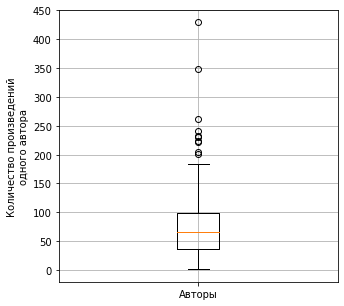

In [60]:
f, axs = plt.subplots(1, 1, figsize=(5, 5))
plt.ylabel("Количество произведений\nодного автора")
plt.yticks(list(range(0, 460, 50)))
y = list(map(lambda v: v[1], xy))
axs.set_xticklabels(["Авторы"])
plt.boxplot(y)
plt.grid()
plt.show()

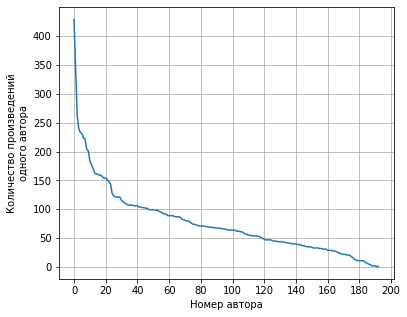

In [55]:
plt.figure(figsize=(6,5))
y = list(map(lambda v: v[1], xy))
x = list(range(len(y)))
plt.yticks(list(range(0, 450, 50)))
plt.xticks(list(range(0, 210, 20)))
plt.xlabel("Номер автора")
plt.ylabel("Количество произведений\nодного автора")
plt.grid()
plt.plot(x,y, label='o')
plt.show()

In [50]:
len(x)

193

In [49]:
print(min(y),max(y), np.mean(y))

1 429 76.92227979274611


In [37]:
df.to_csv("rupoems_dataset.csv", index=False, sep=';')

In [38]:
df

,text,title,author
0,"Забывши волнения жизни мятежной,\nОдин жил в п...",Забывши волнения жизни мятежной...,Михаил Лермонтов
1,"Нивы сжаты, рощи голы,\nОт воды туман и сырост...","Нивы сжаты, рощи голы...",Сергей Есенин
2,Лючинь печальная читала вечером ручьисто-вкрад...,ЧАРЫ ЛЮЧИНЬ,Игорь Северянин
3,"Глыбу кварца разбили молотом,\nИ, веселым огне...",Золото,Анатолий Жигулин
4,"Хлынул дождь, когда девушки, встав в хоровод,\...",Хоровод в Сульдуси,Николай Тихонов
...,...,...,...
14841,Седо\nКурчавятся облака\nНад чернотою полей.\n...,Ноябрь,Леонид Мартынов
14842,"Белокурая Параша,\nСребророзова лицом,\nКоей м...",Параше,Гаврила Державин
14843,"Сладкозвучная богиня,\nРифма золотая,\nСлух ча...",Рифма,Федор Сологуб
14844,Я так любил тебя — до грубых шуток\nИ до таких...,Я так любил тебя — до грубых шуток...,Илья Эренбург


# Train/test split

In [39]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [40]:
BASE_DATASET = "../data/rupoems_dataset.csv"

In [41]:
df = pd.read_csv(BASE_DATASET, sep=';')
print(df.shape)

(14846, 3)


In [42]:
filtered_df =df.drop_duplicates(subset=['text']).reset_index(drop=True)
print(filtered_df.shape[0])

14778


In [43]:
X_train, X_test = train_test_split(filtered_df, test_size=0.15)

In [44]:
X_train.to_csv("train_part.csv", sep=';', index=False)

In [45]:
X_test.to_csv("test_part.csv", sep=';', index=False)